In [30]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import cifar10 as data
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import BatchNormalization, Dropout
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, KFold

In [31]:
#資料型態分布
#箱型圖
def box_graph(data_frame,name_list,name_pre):
    for i in range(len(name_list)):
        plt.figure(figsize=(2,5))
        plt.boxplot(data_frame[name_list[i]],showmeans=True)   
        plt.title(name_pre[i])
        plt.show()
        sns.histplot(data_frame[name_list[i]], kde=True)
        plt.show()
        print("偏態(Skewness): {:.2f}".format(data_frame[name_list[i]].skew()))
        print("峰度(Kurtosis): {:.2f}".format(data_frame[name_list[i]].kurt()))
        print('==================================================================================================')

#特徵關聯圖
def corr_matrix_graph(data_frame):
    corr_matrix = data_frame.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5,fmt='.2f') #各參數代表的意思請查閱seaborn.heatmap官網的說明
    plt.title(' Correlation ')
    plt.show()

In [32]:
#資料前處理
#name_list_outlier =['手機螢幕溫度(平均)','手機螢幕溫度(最大)','手機背蓋溫度(平均)','平均APP運作指標/小時','充電時間指標','手機電池電量','手機外殼/包膜指標','外型平均曲率','上網頻率指標','通話頻率指標','新機/二手/老舊','內容容量比率']
#name_pre_outlier = ['Mobile Screen Temperature (Average)','Mobile Screen Temperature (Max)','Mobile Phone Back Cover Temperature (Average)','Average APP Operation Index/Hour','Charging Time Index','Mobile Phone Battery Level','Mobile Phone Shell/Envelope Index','Average Curvature of Appearance','Internet Frequency Index','Call Frequency Index','New/Used/Old','Content Capacity Ratio','CPU Performance Rating']

#離群值處理
def  outlier_del(data_frame,name_list_outlier):
    for i, name in enumerate(name_list_outlier):
        print(name)
        print("Shape Of The Before Ouliers: ", data_frame[name].shape)
    
        # 计算IQR
        Q1 = np.percentile(data_frame[name], 25)
        Q3 = np.percentile(data_frame[name], 75)
        IQR = Q3 - Q1
        n = 1.5

        # 定义离群值范围
        lower_bound = Q1 - n * IQR
        upper_bound = Q3 + n * IQR

        # 过滤离群值
        filtered_entries = ((data_frame[name] >= lower_bound) & (data_frame[name] <= upper_bound))
        data_frame = data_frame[filtered_entries]
    
        print("Shape Of The After Ouliers: ",data_frame[name].shape)
        print('===================================================================================================================')
    return data_frame

#正規化
def data_normalized(data):
    min_max_scaler = MinMaxScaler()
    data_normalized = min_max_scaler.fit_transform(data)
    return data_normalized

#標準化
def data_standardized(data):
    standard_scaler = StandardScaler()
    data_standardized = standard_scaler.fit_transform(data)
    return data_standardized 


In [33]:
#分割資料集
from sklearn.model_selection import train_test_split
def data_split(x_data,y_data):
    Xtrain, Xtest, ytrain, ytest = train_test_split(x_data, y_data, test_size=0.1, random_state=1,stratify=y_data)
    return Xtrain, Xtest, ytrain, ytest


In [34]:
#submission.csv資料建立
def read_test():
    test=pd.read_excel("01test.xlsx")
    return test
def trans_ans(predicted_ans):
    predicted_classes = (predicted_ans > 0.4).astype(int)
    print(predicted_classes .shape)
    return predicted_classes

In [35]:
#data_train_way
#交叉驗證模型
def create_model(input_dim):
    l2_regularizer = tf.keras.regularizers.l2(0.01)
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(4, activation='relu'),
        tf.keras.layers.Dense(2, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [36]:
#主程式
#read_data
data_frame_train=pd.read_excel("01train.xlsx")
data_frame_ays=pd.read_excel("data_anysis.xlsx")
data_frame_test=pd.read_excel("01test.xlsx")

data_frame_train.describe()


,手機螢幕溫度(平均),手機螢幕溫度(最大),手機背蓋溫度(平均),平均APP運作指標/小時,充電時間指標,手機電池電量,CPU跑分階級,手機外殼/包膜指標,外型平均曲率,上網頻率指標,通話頻率指標,新機/二手/老舊,內容容量比率,CPU效能等級,Underclocking
count,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000,3903.000000
mean,38.984541,45.294944,52.784871,656.507337,0.225864,75.190124,3.319754,0.109481,0.015342,2553.566565,2209.062206,0.297463,0.833713,1.319754,0.428132
std,14.540574,15.546263,64.786127,717.237752,0.232311,14.008806,0.684632,0.090865,0.125137,1829.663990,1810.428997,0.572666,12.506317,0.684632,0.494871
min,7.902370,8.047619,2.562656,-8000.000000,0.000000,47.889610,3.000000,0.003690,-1.043000,0.675070,0.000000,0.000000,-600.000000,1.000000,0.000000
25%,28.642857,34.880952,43.504429,224.700000,0.030303,62.761544,3.000000,0.058475,-0.055860,948.100000,579.800000,0.000000,0.802960,1.000000,0.000000
50%,38.976190,47.023810,53.053333,413.100000,0.142857,76.677489,3.000000,0.085307,0.005701,2276.000000,1898.000000,0.000000,0.937191,1.000000,0.000000
75%,50.119048,57.345238,60.650000,834.969651,0.371429,86.821260,3.000000,0.143723,0.078966,3839.552040,3455.073327,1.000000,0.987258,1.000000,1.000000
max,75.619048,79.547619,4000.000000,4412.000000,0.966667,100.000000,6.000000,1.776212,1.208233,8410.000000,8129.000000,5.000000,500.000000,4.000000,1.000000


In [37]:
#data arrange
#outlier
name_list_outlier =['手機螢幕溫度(平均)','手機螢幕溫度(最大)','手機背蓋溫度(平均)','平均APP運作指標/小時','充電時間指標','手機電池電量','手機外殼/包膜指標','外型平均曲率','上網頻率指標','通話頻率指標','新機/二手/老舊','內容容量比率']
name_pre_outlier = ['Mobile Screen Temperature (Average)','Mobile Screen Temperature (Max)','Mobile Phone Back Cover Temperature (Average)','Average APP Operation Index/Hour','Charging Time Index','Mobile Phone Battery Level','Mobile Phone Shell/Envelope Index','Average Curvature of Appearance','Internet Frequency Index','Call Frequency Index','New/Used/Old','Content Capacity Ratio','CPU Performance Rating']
data_frame_arrange=outlier_del(data_frame_train,name_list_outlier)
data_frame_arrange.describe()





手機螢幕溫度(平均)
Shape Of The Before Ouliers:  (3903,)
Shape Of The After Ouliers:  (3903,)
手機螢幕溫度(最大)
Shape Of The Before Ouliers:  (3903,)
Shape Of The After Ouliers:  (3903,)
手機背蓋溫度(平均)
Shape Of The Before Ouliers:  (3903,)
Shape Of The After Ouliers:  (3783,)
平均APP運作指標/小時
Shape Of The Before Ouliers:  (3783,)
Shape Of The After Ouliers:  (3528,)
充電時間指標
Shape Of The Before Ouliers:  (3528,)
Shape Of The After Ouliers:  (3504,)
手機電池電量
Shape Of The Before Ouliers:  (3504,)
Shape Of The After Ouliers:  (3504,)
手機外殼/包膜指標
Shape Of The Before Ouliers:  (3504,)
Shape Of The After Ouliers:  (3422,)
外型平均曲率
Shape Of The Before Ouliers:  (3422,)
Shape Of The After Ouliers:  (3312,)
上網頻率指標
Shape Of The Before Ouliers:  (3312,)
Shape Of The After Ouliers:  (3295,)
通話頻率指標
Shape Of The Before Ouliers:  (3295,)
Shape Of The After Ouliers:  (3292,)
新機/二手/老舊
Shape Of The Before Ouliers:  (3292,)
Shape Of The After Ouliers:  (3268,)
內容容量比率
Shape Of The Before Ouliers:  (3268,)
Shape Of The After Ouliers:  (

,手機螢幕溫度(平均),手機螢幕溫度(最大),手機背蓋溫度(平均),平均APP運作指標/小時,充電時間指標,手機電池電量,CPU跑分階級,手機外殼/包膜指標,外型平均曲率,上網頻率指標,通話頻率指標,新機/二手/老舊,內容容量比率,CPU效能等級,Underclocking
count,3062.000000,3062.000000,3062.000000,3062.000000,3062.000000,3062.000000,3062.000000,3062.000000,3062.000000,3062.000000,3062.000000,3062.000000,3062.000000,3062.000000,3062.000000
mean,40.206324,46.756998,52.485389,549.467909,0.220479,75.042229,3.199869,0.101382,0.008337,2499.159158,2145.558616,0.297191,0.899709,1.199869,0.423579
std,13.705266,14.443762,11.910280,398.321287,0.226673,14.152963,0.524997,0.052438,0.098292,1633.831873,1622.022043,0.518698,0.113727,0.524997,0.494206
min,8.728243,9.761905,18.565749,2.806544,0.000000,47.889610,3.000000,0.003690,-0.260300,0.675070,0.000000,0.000000,0.543072,1.000000,0.000000
25%,30.142857,36.380952,44.662532,238.800000,0.026573,62.693903,3.000000,0.058508,-0.058215,1136.250000,750.082196,0.000000,0.840724,1.000000,0.000000
50%,39.976190,47.714286,53.395807,427.600000,0.138410,75.856782,3.000000,0.085238,0.003792,2285.000000,1922.000000,0.000000,0.947540,1.000000,0.000000
75%,50.642857,57.952381,60.555000,766.175000,0.369821,88.144841,3.000000,0.141974,0.069428,3689.750000,3328.703401,1.000000,0.988329,1.000000,1.000000
max,75.619048,79.547619,86.000000,1775.000000,0.883117,100.000000,6.000000,0.269723,0.281614,7427.000000,7241.000000,2.000000,1.000000,4.000000,1.000000


In [38]:
#分割
y_data = data_frame_arrange['Underclocking'].to_numpy()
feature_ex = ['手機螢幕溫度(平均)','手機背蓋溫度(平均)','平均APP運作指標/小時','充電時間指標','手機電池電量','CPU跑分階級','手機外殼/包膜指標','外型平均曲率','新機/二手/老舊']
x_data = data_frame_arrange[feature_ex].to_numpy()
Xtrain, Xtest, ytrain, ytest=data_split(x_data,y_data)

#data arrange
#正規化
x_data =data_normalized(x_data )
print("数据类型:", type(x_data ))


Xtrain, Xtest, ytrain, ytest=data_split(x_data,y_data)
print("Xtrain shape:", Xtrain.shape)
print("Xtrain type:", type(Xtrain))
print("Xtest shape:", Xtest.shape)
print("Xtest type:", type(Xtest))
print("ytrain shape:", ytrain.shape)
print("ytrain type:", type(ytrain))
print("ytest shape:", ytest.shape)
print("ytest type:", type(ytest))



数据类型: <class 'numpy.ndarray'>
Xtrain shape: (2755, 9)
Xtrain type: <class 'numpy.ndarray'>
Xtest shape: (307, 9)
Xtest type: <class 'numpy.ndarray'>
ytrain shape: (2755,)
ytrain type: <class 'numpy.ndarray'>
ytest shape: (307,)
ytest type: <class 'numpy.ndarray'>


In [39]:
#model-cross 
kf = KFold(n_splits=10, shuffle=True, random_state=42)

scores = []
input_dim = x_data.shape[1]  # 获取输入特征的数量

for train_index, test_index in kf.split(x_data):
    # 分割数据
    x_train, x_test = x_data[train_index], x_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    
    # 创建模型
    model = create_model(input_dim)
    
    # 训练模型
    model.fit(x_train, y_train, epochs=50, batch_size=32, verbose=1)
    
    # 评估模型
    score = model.evaluate(x_test, y_test, verbose=0)
    scores.append(score[1])  # 假设我们关心的是准确率

# 打印每折的准确率以及平均准确率
print("每折的准确率:", scores)
print("平均准确率:", np.mean(scores))


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step - accuracy: 0.5816 - loss: 0.6834 
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 399us/step - accuracy: 0.5691 - loss: 0.6800
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - accuracy: 0.5856 - loss: 0.6716
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step - accuracy: 0.5777 - loss: 0.6737
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step - accuracy: 0.5920 - loss: 0.6611
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - accuracy: 0.6062 - loss: 0.6594
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step - accuracy: 0.6258 - loss: 0.6590
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step - accuracy: 0.6122 - loss: 0.6574
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step - accuracy: 0.6095 - loss: 0.6653
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step - accuracy: 0.6150 - loss: 0.6526
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step - accuracy: 0.6282 - loss: 0.6585
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/ste

In [40]:
l2_regularizer = tf.keras.regularizers.l2(0.01)
input_features = x_data.shape[1]
print( x_data.shape[1])
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_features,)),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(2, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),    
])
model.summary()

9


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_200 (Dense)               │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_203 (Dense)               │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,433 (13.41 KB)

 Trainable params: 3,433 (13.41 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(Xtrain, ytrain, batch_size=32, epochs=100,validation_split=0.1 ) #default batch=32
print(history.history.keys())


Epoch 1/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5424 - loss: 0.6987 - val_accuracy: 0.6087 - val_loss: 0.6752
Epoch 2/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.5545 - loss: 0.6874 - val_accuracy: 0.6087 - val_loss: 0.6697
Epoch 3/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.5584 - loss: 0.6882 - val_accuracy: 0.6087 - val_loss: 0.6702
Epoch 4/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.5713 - loss: 0.6841 - val_accuracy: 0.6087 - val_loss: 0.6746
Epoch 5/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.5765 - loss: 0.6822 - val_accuracy: 0.6087 - val_loss: 0.6770
Epoch 6/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.5842 - loss: 0.6828 - val_accuracy: 0.6087 - val_loss: 0.6762
Epoch 7/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.5725 - loss: 0.6842 - val_accuracy: 0.6087 - val_loss: 0.6694
Epoch 8/100
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.5550 - loss: 0.6920 - val_accura

In [42]:
results = model.evaluate(Xtest, ytest)
print('Final test set loss: {:4f}'.format(results[0]))
print('Final test set accuracy: {:4f}'.format(results[1]))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step - accuracy: 0.5734 - loss: 0.6823
Final test set loss: 0.681390
Final test set accuracy: 0.576547


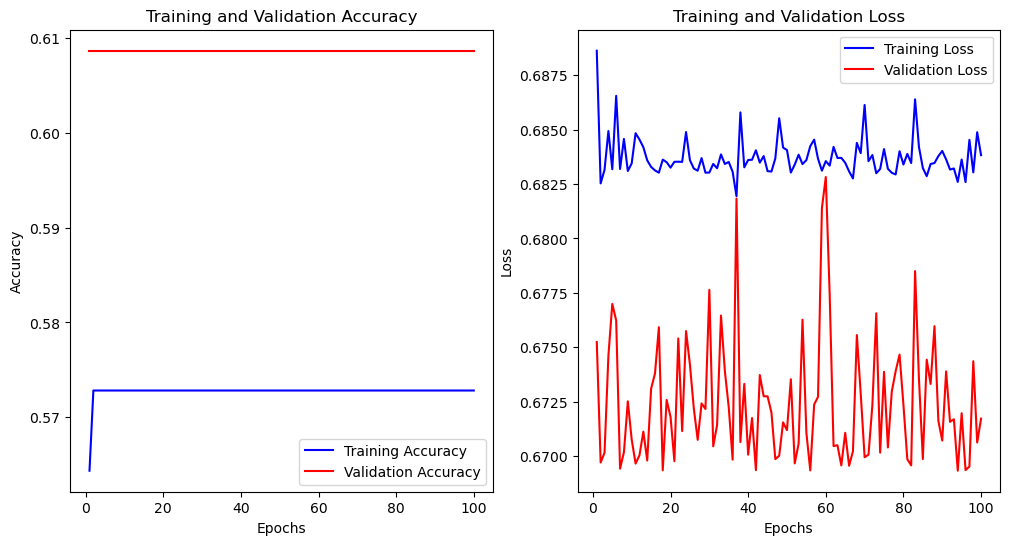

In [43]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_ = range(1,len(acc)+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_, acc, 'b-', label='Training Accuracy')
plt.plot(epochs_, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_, loss, 'b-', label='Training Loss')
plt.plot(epochs_, val_loss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()